In [1]:
import torch
import numpy as np
import os
from torch.utils.data import Dataset
from skimage.transform import resize
#from torchsummary import summary
import pandas as pd
import psutil
import matplotlib.pyplot as plt

from datetime import datetime
startTime = datetime.now()

In [3]:
threads = round(psutil.cpu_count()/2)
torch.set_num_threads(threads)
print(torch.__config__.parallel_info())

ATen/Parallel:
	at::get_num_threads() : 4
	at::get_num_interop_threads() : 4
OpenMP 201811
	omp_get_max_threads() : 4
Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220801 for Intel(R) 64 architecture applications
	mkl_get_max_threads() : 4
Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
std::thread::hardware_concurrency() : 8
Environment variables:
	OMP_NUM_THREADS : [not set]
	MKL_NUM_THREADS : [not set]
ATen parallel backend: OpenMP



For a conv2D, input should be in (N, C, H, W) format. 
N is the number of samples/batch_size. 
C is the channels. 
H and W are height and width resp.

In [4]:
TRAIN_IMG_PATH = 'train/image'
TRAIN_LABEL_PATH = 'train/label'
VAL_IMG_PATH = 'val/image'
VAL_LABEL_PATH = 'val/label'
BATCHSIZE = 32
IMAGESIZE = 128

In [5]:
#https://www.kaggle.com/code/ivanshingel/cars-segmentation-research
class CityscapesDataset(Dataset):
    def __init__(self, transforms= None, train= True):
        self.train = train
        self.images_path = TRAIN_IMG_PATH
        self.labels_path = TRAIN_LABEL_PATH
        if not train:
            self.images_path = VAL_IMG_PATH
            self.labels_path = VAL_LABEL_PATH
            
        self.len = len(os.listdir(self.images_path))
        
    def __getitem__(self, index):
        #load sample {img,,label}
        naming_label = int(os.listdir(self.images_path)[index].split('.')[0])
        image = np.asarray(np.load(os.path.join(self.images_path, f'{os.listdir(self.images_path)[index]}')), 
                                            dtype= np.float32)
        image = resize(image, (IMAGESIZE, IMAGESIZE))
        image = torch.from_numpy(image)
        image = image / 255
        image = image.permute(2, 0, 1)
        
        labelSuffix = '_label'
        label = np.load(os.path.join(self.labels_path, f'{naming_label}{labelSuffix}.npy'))
        label = resize(label, (IMAGESIZE, IMAGESIZE))
        label = torch.from_numpy(label)
        label = torch.Tensor(label)
        label = label.reshape(1, IMAGESIZE, IMAGESIZE)
        label = label + 1
        
        return image, label
    
    def __len__(self):
        return self.len

In [6]:
def show_img_and_mask(img, label, epoch = None):
    if epoch != None:
        fig = plt.figure(figsize=(10, 7))
        fig.add_subplot(1, 2, 1)
        img = img.permute(1,2,0)
        plt.imshow(img * IMAGESIZE)
        fig.add_subplot(1, 2, 2)
        plt.imshow(label.permute(1,2,0))
        plt.savefig('pic/epoch_'+str(epoch)+'.png')
    else:
        fig = plt.figure(figsize=(10, 7))
        fig.add_subplot(1, 2, 1)
        img = img.permute(1,2,0)
        plt.imshow(img * IMAGESIZE)
        fig.add_subplot(1, 2, 2)
        plt.imshow(label.permute(1,2,0))
        
    return

In [7]:
training_set = CityscapesDataset(train=True)
validation_set = CityscapesDataset(train=False)

In [8]:
#https://pytorch.org/tutorials/beginner/introyt/trainingyt.html
training_loader = torch.utils.data.DataLoader(training_set, batch_size=BATCHSIZE, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=BATCHSIZE, shuffle=False)

In [9]:
class FCN(torch.nn.Module):

    def __init__(self):
        super(FCN, self).__init__()
        self.activation = torch.nn.ReLU()
        #Fist step - down
        self.layer1Conv1 = torch.nn.Conv2d(in_channels= 3, out_channels= 32, kernel_size=(3, 3), padding= 1)
        self.layer1Norm1 = torch.nn.BatchNorm2d(32)
        self.layer1Conv2 = torch.nn.Conv2d(in_channels= 32, out_channels= 32, kernel_size=(3, 3), padding= 1)
        self.layer1Norm2 = torch.nn.BatchNorm2d(32)
        #Max pooling  - down
        self.layer1Pool1 = torch.nn.MaxPool2d((2,2), stride=2)

        #Second step  - down
        self.layer2Conv1 = torch.nn.Conv2d(in_channels= 32, out_channels= 32, kernel_size=(3, 3), padding= 1)
        self.layer2Norm1 = torch.nn.BatchNorm2d(32)
        self.layer2Conv2 = torch.nn.Conv2d(in_channels= 32, out_channels= 32, kernel_size=(3, 3), padding= 1)
        self.layer2Norm2 = torch.nn.BatchNorm2d(32)
        #Max pooling - down
        self.layer2Pool1 = torch.nn.MaxPool2d((2,2), stride=2)

        #Third step - down
        self.layer3Conv1 = torch.nn.Conv2d(in_channels= 32, out_channels= 256, kernel_size=(3, 3), padding= 1)
        self.layer3Norm1 = torch.nn.BatchNorm2d(256)
        self.layer3Conv2 = torch.nn.Conv2d(in_channels= 256, out_channels= 256, kernel_size=(3, 3), padding= 1)
        self.layer3Norm2 = torch.nn.BatchNorm2d(256)
        #Max pooling - down
        self.layer3Pool1 = torch.nn.MaxPool2d((2,2), stride=2)

        #Fourth step - middel
        self.layer4Conv1 = torch.nn.Conv2d(in_channels= 256, out_channels= 512, kernel_size=(3, 3), padding= 1)
        self.layer4Norm1 = torch.nn.BatchNorm2d(512)
        self.layer4Conv2 = torch.nn.Conv2d(in_channels= 512, out_channels= 512, kernel_size=(3, 3), padding= 1)
        self.layer4Norm2 = torch.nn.BatchNorm2d(512)
        #Transpose convelution - up
        self.layer4transpose1 = torch.nn.ConvTranspose2d(in_channels= 512, out_channels= 256, kernel_size=(2,2), stride=2)

        #Fifth step - up
        self.layer5Conv1 = torch.nn.Conv2d(in_channels= 512, out_channels= 256, kernel_size=(3, 3), padding= 1)
        self.layer5Norm1 = torch.nn.BatchNorm2d(256)
        self.layer5Conv2 = torch.nn.Conv2d(in_channels= 256, out_channels= 256, kernel_size=(3, 3), padding= 1)
        self.layer5Norm2 = torch.nn.BatchNorm2d(256)
        #Transpose convelution - up
        self.layer5transpose1 = torch.nn.ConvTranspose2d(in_channels= 256, out_channels= 224, kernel_size=(2,2), stride=2)

        #Sixth step - up
        self.layer6Conv1 = torch.nn.Conv2d(in_channels= 256, out_channels= 32, kernel_size=(3, 3), padding= 1)
        self.layer6Norm1 = torch.nn.BatchNorm2d(32)
        self.layer6Conv2 = torch.nn.Conv2d(in_channels= 32, out_channels= 32, kernel_size=(3, 3), padding= 1)
        self.layer6Norm2 = torch.nn.BatchNorm2d(32)
        #Transpose convelution - up
        self.layer6transpose1 = torch.nn.ConvTranspose2d(in_channels= 32, out_channels= 32, kernel_size=(2,2), stride=2)

        #Seventh step - up
        self.layer7Conv1 = torch.nn.Conv2d(in_channels= 64, out_channels= 32, kernel_size=(3, 3), padding= 1)
        self.layer7Norm1 = torch.nn.BatchNorm2d(32)
        self.layer7Conv2 = torch.nn.Conv2d(in_channels= 32, out_channels= 32, kernel_size=(3, 3), padding= 1)
        self.layer7Norm2 = torch.nn.BatchNorm2d(32)
        #Merge into one picture for final output
        self.layer7Conv3 = torch.nn.Conv2d(in_channels= 32, out_channels= 1, kernel_size=(3, 3), padding= 1)
        self.layer7Norm3 = torch.nn.BatchNorm2d(1)

    def forward(self, x):
        #Step 1
        x = self.layer1Conv1(x)
        x = self.layer1Norm1(x)
        x = self.activation(x)

        x = self.layer1Conv2(x)
        x = self.layer1Norm2(x)
        layer1Skip1 = self.activation(x)

        x = self.layer1Pool1(layer1Skip1)

        #Step 2
        x = self.layer2Conv1(x)
        x = self.layer2Norm1(x)
        x = self.activation(x)

        x = self.layer2Conv2(x)
        x = self.layer2Norm2(x)
        layer2Skip1 = self.activation(x)

        x = self.layer2Pool1(layer2Skip1)

        #Step 3
        x = self.layer3Conv1(x)
        x = self.layer3Norm1(x)
        x = self.activation(x)

        x = self.layer3Conv2(x)
        x = self.layer3Norm2(x)
        layer3Skip1 = self.activation(x)

        x = self.layer3Pool1(layer3Skip1)

        #Step 4
        x = self.layer4Conv1(x)
        x = self.layer4Norm1(x)
        x = self.activation(x)

        x = self.layer4Conv2(x)
        x = self.layer4Norm2(x)
        x = self.activation(x)
        
        x = self.layer4transpose1(x)

        #Merge step 4 with skip 3
        x = torch.cat((layer3Skip1, x), 1) 

        #Step 5
        x = self.layer5Conv1(x)
        x = self.layer5Norm1(x)
        x = self.activation(x)

        x = self.layer5Conv2(x)
        x = self.layer5Norm2(x)
        x = self.activation(x)

        x = self.layer5transpose1(x)

        #Merge step 5 with skip 2
        x = torch.cat((layer2Skip1, x), 1) 

        #Step 6
        x = self.layer6Conv1(x)
        x = self.layer6Norm1(x)
        x = self.activation(x)

        x = self.layer6Conv2(x)
        x = self.layer6Norm2(x)
        x = self.activation(x)

        x = self.layer6transpose1(x)

        #Merge step 6 with skip 2
        x = torch.cat((layer1Skip1, x), 1) 

        #Step 7
        x = self.layer7Conv1(x)
        x = self.layer7Norm1(x)
        x = self.activation(x)

        x = self.layer7Conv2(x)
        x = self.layer7Norm2(x)
        x = self.activation(x)

        #Make the prediction
        x = self.layer7Conv3(x)
        x = self.layer7Norm3(x)
        x = self.activation(x)

        return x

model = FCN()

In [10]:
#Input size
#summary(model, input_size = (3,128, 128))

# Train model

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
loss_fn = torch.nn.CrossEntropyLoss()

In [12]:
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for b, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        # Zero your gradients for every batch!
        optimizer.zero_grad()
        # Make predictions for this batch
        outputs = model(inputs)
        # Compute the loss and its gradients
        loss = 0
        for e in range(len(outputs)):
                temploss = loss_fn(outputs[e], labels[e])/(IMAGESIZE)
                loss += temploss
        loss = loss / BATCHSIZE
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if b % 10 == 9:
            last_loss = running_loss / b # loss per batch
            print('  batch {} loss: {}'.format(b + 1, last_loss))

    return last_loss

EPOCH 1:
  batch 10 loss: 21.23646033233139
  batch 20 loss: 20.21096008555904
  batch 30 loss: 19.938465497990453
  batch 40 loss: 19.71855251948435
  batch 50 loss: 19.597434303019416
  batch 60 loss: 19.523946969393872
  batch 70 loss: 19.53654527993518
  batch 80 loss: 19.446747413490108
LOSS train 19.446747413490108 valid 0.14757158387178307
model saved
EPOCH 2:
  batch 10 loss: 21.344350020061775


KeyboardInterrupt: 

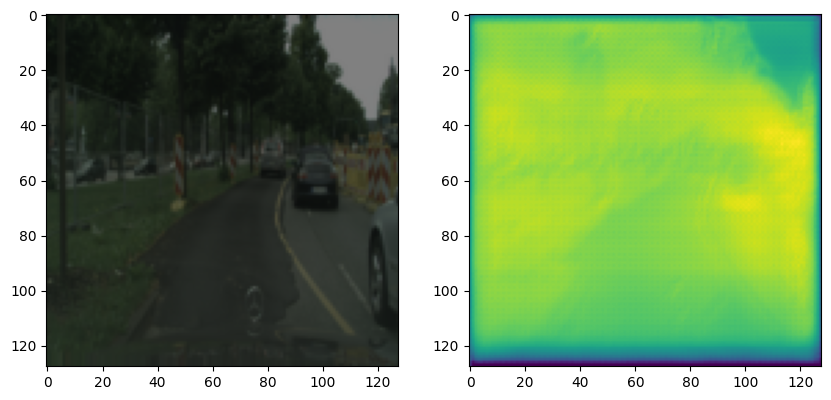

In [14]:
epoch_number = 0

EPOCHS = 3

best_vloss = 1_000_000.

timeLine = []

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number)

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = 0
            for e in range(len(voutputs)):
                    if i == 1 and e == 1:
                        show_img_and_mask(vinputs[e], voutputs[e], epoch=epoch)
                    temploss = loss_fn(voutputs[e], vlabels[e])/(IMAGESIZE*IMAGESIZE)
                    vloss += temploss
            running_vloss += vloss/BATCHSIZE

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    timeLine.append([epoch, avg_loss, avg_vloss.item()])
    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        print('model saved')
        best_vloss = avg_vloss
        model_path = 'models/model_{}'.format(epoch_number)
        torch.save(model.state_dict(), model_path)
    pd.DataFrame(timeLine, columns= ['Epoch', 'Train Loss', 'Validation Loss']).to_csv('loss.csv')
    epoch_number += 1

In [ ]:
print(datetime.now() - startTime)